In [1]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from sklearn.metrics import confusion_matrix,balanced_accuracy_score,roc_auc_score,roc_curve
from p4tools import io

In [12]:
ResultsPath = '../../Data/SummaryResults/'
FiguresPath = '../../Data/Figures/'
if not os.path.isdir(FiguresPath):
    os.mkdir(FiguresPath)
    
NumRepeats=3

ResultsList=[]
for Rep in range(NumRepeats):
    ResultsList.append(pd.read_csv(ResultsPath+'TileClassifier_LORO_final_repeat'+str(Rep)+'.csv'))
    
Y_true=ResultsList[-1]['GroundTruth'].astype('uint8')

Y_pred=ResultsList[0]['ClassifierConf'].values
for Rep in range(1,NumRepeats):
    Y_pred=Y_pred+ResultsList[Rep]['ClassifierConf'].values
Y_pred=Y_pred/NumRepeats

Results_df = ResultsList[-1]
Results_df['ClassifierConf']=Y_pred

In [13]:
Recall95PC_Threshold=0.24

AUC = roc_auc_score(Y_true, Y_pred)
conf_matrix = confusion_matrix(Y_true,Y_pred>Recall95PC_Threshold,labels=[0,1])
Sensitivity = conf_matrix[1,1]/(conf_matrix[1,0]+conf_matrix[1,1])
Specificity = conf_matrix[0,0]/(conf_matrix[0,0]+conf_matrix[0,1])
Precision = conf_matrix[1,1]/(conf_matrix[1,1]+conf_matrix[0,1])
Balanced_accuracy = balanced_accuracy_score(Y_true, Y_pred>Recall95PC_Threshold)

print('Number of tiles classified in Leave-One-Region-Out Cross-Validation= ',Results_df.shape[0])
print('')
print('Confusion matrix = ')
print(conf_matrix)
print('')
print('sensitivity=',round(100*Sensitivity,2),'%')
print('Specificity=',round(100*Specificity,2),'%')
print('Precision=',round(100*Precision,2),'%')
print('AUC=',round(AUC,3))
print('Balanced Accuracy =',round(100*Balanced_accuracy))



Number of tiles classified in Leave-One-Region-Out Cross-Validation=  42904

Confusion matrix = 
[[ 5388  4513]
 [ 1661 31342]]

sensitivity= 94.97 %
Specificity= 54.42 %
Precision= 87.41 %
AUC= 0.934
Balanced Accuracy = 75


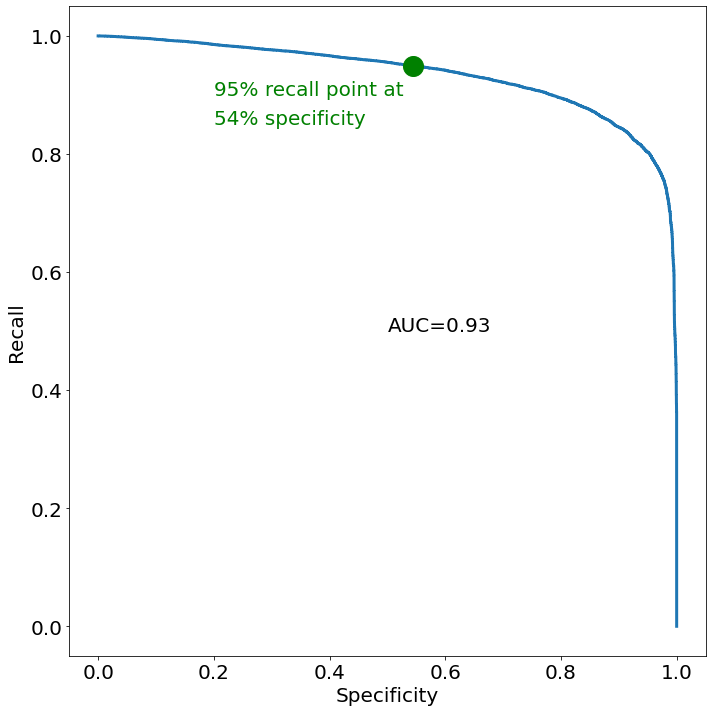

In [14]:
fig = plt.figure(figsize=(10,10))
fpr, tpr, thresholds = roc_curve(Y_true, Y_pred)
plt.plot(1-fpr,tpr,linewidth=3)
plt.xlabel('Specificity',fontsize=20)
plt.ylabel('Recall',fontsize=20)

plt.plot(Specificity,Sensitivity,'og',linewidth=30,markersize=20)

plt.text(0.5, 0.5, 'AUC='+str(round(AUC,2)), fontsize=20)
plt.text(0.2, 0.9, '95% recall point at', fontsize=20,color='green')
plt.text(0.2, 0.85, '54% specificity', fontsize=20,color='green')


matplotlib.rc('xtick', labelsize=20) 
matplotlib.rc('ytick', labelsize=20)

fig.tight_layout()
plt.savefig(FiguresPath+'Figure13.pdf')
plt.show()

Number of P4 regions =  28


/home/mdmcdonn/anaconda3/envs/HiRISE_ML/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1814: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')


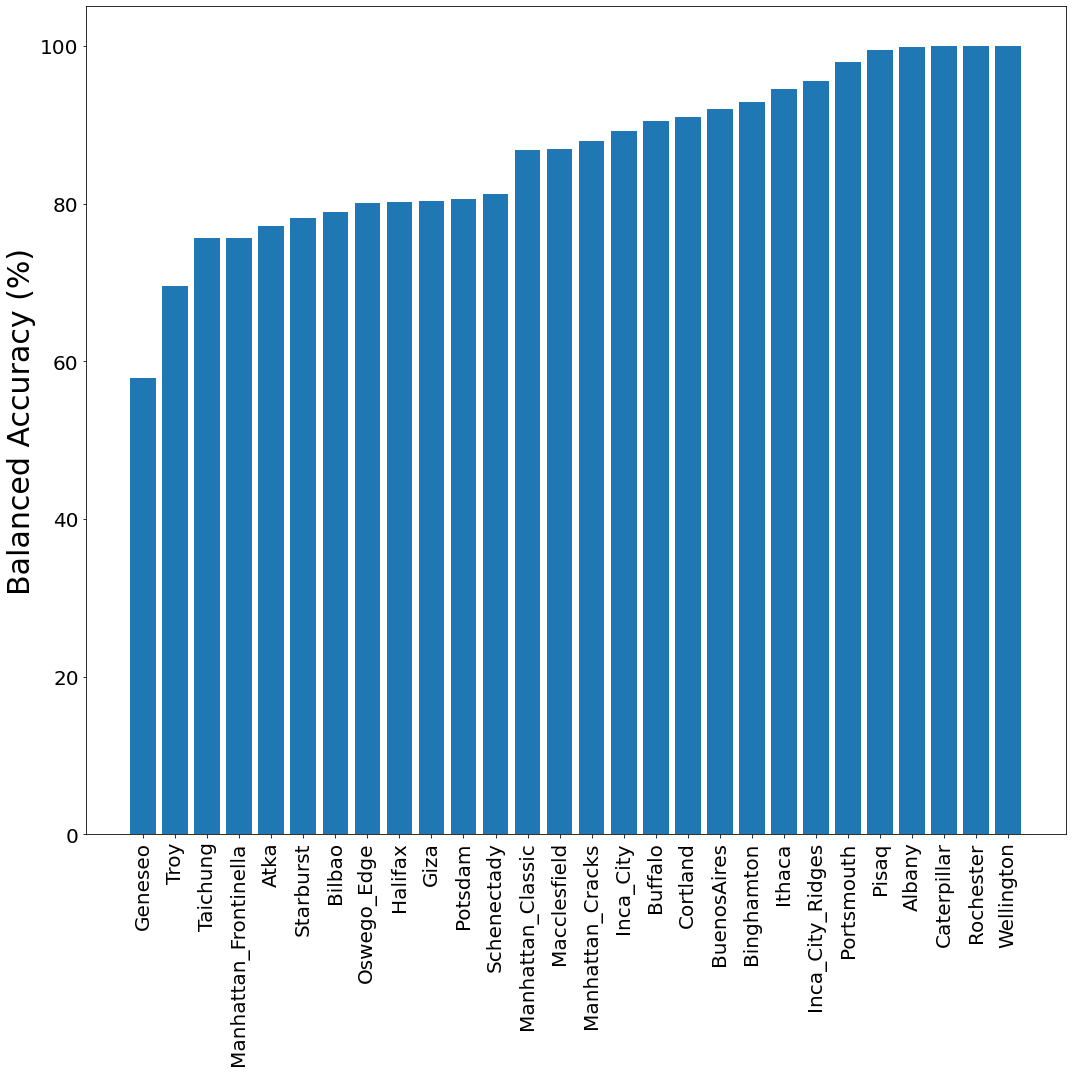

In [15]:
#regions
region_names_df = io.get_region_names()
region_names_df = region_names_df.set_index('obsid')
region_names_df.at['ESP_012620_0975','roi_name'] = 'Buffalo'
region_names_df.at['ESP_012277_0975','roi_name'] = 'Buffalo'
region_names_df.at['ESP_012348_0975','roi_name'] = 'Taichung'

#other meta data
ImageResults_df = io.get_meta_data()
ImageResults_df = ImageResults_df.set_index('OBSERVATION_ID')
ImageResults_df = pd.concat([ImageResults_df, region_names_df], axis=1, sort=False)
ImageResults_df=ImageResults_df.dropna()
UniqueP4Regions = ImageResults_df['roi_name'].unique()
print("Number of P4 regions = ",len(UniqueP4Regions))

BAs=[]
for ToLeaveOut in UniqueP4Regions:
    This_df = Results_df[Results_df['Region']==ToLeaveOut]
    y_true = This_df['GroundTruth'].values
    y_pred = This_df['ClassifierConf'].values
    Balanced_accuracy_cl = balanced_accuracy_score(y_true, y_pred>0.5)
    BAs.append(Balanced_accuracy_cl)
regions_sorted=[x for y, x in sorted(zip(BAs,UniqueP4Regions))]

fig=plt.figure(figsize=(15,15))
plt.bar(regions_sorted,100*np.array(sorted(BAs)))
ax=fig.gca()
ax.set_xticks(np.arange(0,len(regions_sorted)))
ax.set_xticklabels(regions_sorted,rotation=90,fontsize=20)
ax.set_ylabel('Balanced Accuracy (%)',fontsize=30)
matplotlib.rc('xtick', labelsize=30) 
matplotlib.rc('ytick', labelsize=30)
fig.tight_layout()
plt.savefig(FiguresPath+'Figure14.pdf')
plt.show()